In [1]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def one_hot_encode(Y):
    n_features = np.max(np.unique(Y)) + 1

    Y_train = []

    for i in range(Y.shape[0]):
        y = np.zeros(n_features)
        idx = Y[i]
        y[idx] = 1
        Y_train += [y]
    return np.array(Y_train)

In [3]:
class FLD:
    def __init__(self):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.mean_vectors = None
        self.sw = None
        self.sb = None
        self.w = None
        self.slope = None

    def fit(self, X, y):
        n_samples, n_features = y.shape

        # Find mean vectors first
        self.mean_vectors = [] 
        for i in range(n_features):
            cond = y[:,i] == 1
            _mean = X[cond].mean(0)

            self.mean_vectors += [_mean]
        self.mean_vectors = np.array(self.mean_vectors)

        # Get Within-class scatter matrix
        self.sw = []
        for i in range(n_features):
            cond = y[:,i] == 1
            x = X[cond]
            for j in range(x.shape[0]):
                part1 = (x[j] - self.mean_vectors[0]).reshape(-1,1)
                part2 = part1.T
                self.sw += [part1 @ part2]
        self.sw = np.sum(self.sw, 0)

        # Get Between-class scatter matrix
        total_mean = X.mean(0)

        self.sb = []
        
        for i in range(n_features):
            cond = y[:,i] == 1
            N = np.sum(cond)
            m1 = total_mean.reshape(-1,1)
            m2 = self.mean_vectors[i].reshape(-1,1)
            self.sb += [N * m1 @ m2.T]
        self.sb = np.sum(self.sb, 0)

        # Solving the generalized eigenvalue problem for the matrix
        eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(self.sw).dot(self.sb))

        # eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

        self.w = eig_vecs[0]

    def predict_using_class_mean(self, X, y, X_test):
        self.fit(X, y)

        n_vectors = len(self.mean_vectors)
        predictions = []
        for i in range(n_vectors):
            _y = np.linalg.norm(X_test - self.mean_vectors[i], axis=1)
            predictions += [_y]
        predictions = np.array(predictions)

        y_pred = np.argmax(predictions, 0)
        
        return y_pred

    def predict_using_knn(self, X, y, X_test, k=1):
        n_samples, n_features = y.shape
        self.fit(X, y)
        
        proj_x_train = X @ self.w
        proj_x_test = X_test @ self.w

        y_pred = []
        for x in proj_x_test:
            dist = np.linalg.norm(proj_x_train - x.reshape(-1,1), axis=0) 

            idxs = dist.argsort()[:k]

            pred = y[idxs].sum(0)
            label = np.argmax(pred)
            y_pred += [label]

        y_pred = np.array(y_pred)

        return y_pred
        pass
    def plot_projection(self, X, y, shift_slope=[0,0]):
        w = self.w

        # X = X_train
        # y = y_train
        X = np.matrix(X)
        n_samples, n_features = y.shape

        # Compute
        slope = w[1]/w[0]

        # Projected X
        # https://stats.stackexchange.com/questions/270148/fisher-linear-discriminant-analysis-method-projections-of-all-the-data-samples-t
        projected_x = (X @ w).T * w / (w @ w) - (np.eye(w.size) @ np.array([shift_slope]).T).T

        # Plotting
        fig, ax = plt.subplots(figsize=(10,10))

        # line = ax.axline((0,0), slope=slope, color='k')

        colors = ['r', 'g', 'b']

        for i in range(n_features):
            cond = y[:, i] == 1
        
            # Plot original data
            ax.plot(X[cond,0], X[cond,1], colors[i]+'.')

            ax.plot(projected_x[cond,0], projected_x[cond,1], colors[i]+'^')

            for j in range(sum(cond)):
                src = [X[cond,0][j,0], (projected_x[cond,0])[j,0]]
                dst = [X[cond,1][j,0], (projected_x[cond,1])[j,0]]

                ax.plot(src, dst, colors[i], alpha=0.07)

        # Compute weight and bias to display them
        pointX = np.array(projected_x[0])[0]
        pointY = np.array(projected_x[-1])[0]
        _y = pointX[1] - pointY[1]
        _x = pointX[0] - pointY[0]
        weight = _y / _x
        bias = projected_x[0][0,1] - weight * projected_x[0][0,0]
        # Also plot it to make sure that it's correct
        _x = np.arange(-14, 10)
        _y = weight * _x + bias
        plt.plot(_x, _y, 'k--')

        ax.set_title('Projection line w={:}, b={:}'.format(weight,bias))

    def accuracy_score(self, y, y_pred):
        TP, TN, FP, FN = self.compute_confusion_values(y, y_pred)

        acc = (TP + TN) / (TP + TN + FP + FN)
        
        return acc

    def compute_confusion_values(self, y, y_pred):
        N = y.shape[-1]
        
        onehot_y_pred = one_hot_encode(y_pred)
        # onehot_y_pred = one_hot_encode(np.argmax(y_pred, 1))

        TP = 0
        TN = 0
        FP = 0
        FN = 0

        for i in range(N):
            TP += ((onehot_y_pred[:,0] == 1) & (y[:,0] == 1)).sum()
            TN += ((onehot_y_pred[:,0] == 0) & (y[:,0] == 0)).sum()
            FP += ((onehot_y_pred[:,0] == 1) & (y[:,0] == 0)).sum()
            FN += ((onehot_y_pred[:,0] == 0) & (y[:,0] == 1)).sum()

        TP /= N
        TN /= N
        FP /= N
        FN /= N

        return TP, TN, FP, FN

    def show_confusion_matrix(self, y, y_pred):
        N = y.shape[-1]

        # prepare predictions
        # y_pred = self.predict(X)
        
        onehot_y_pred = one_hot_encode(y_pred)

        confusion_matrix = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                confusion_matrix[i, j] = ((onehot_y_pred[:,i] == 1) & (y[:,j] == 1)).sum()

        fig, ax = plt.subplots()
        im = ax.imshow(confusion_matrix)

        thresh = confusion_matrix.max() / 2.
        for i in range(N):
            for j in range(N):
                ax.text(j, i, format(confusion_matrix[i, j], '.2f'),
                        ha="center", va="center",
                        color="white" if confusion_matrix[i, j] < thresh else "black")
        plt.colorbar(im)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Confusion matrix')

In [4]:
class MultiClassLogisticRegression:
    
    def __init__(self, dim_in, dim_out):
        """
            You can add/change any variables/methods to meet your need.
        """
        self.epoch = []
        self.train_loss = []
        self.weights = None
        
        # Weight init
        self.weights = np.random.rand(dim_in+1, dim_out)
        # self.weights = np.random.rand(X.shape[-1] + 1, y.shape[-1])

    def add_dim(self, X):
        new_X = np.zeros((X.shape[0], X.shape[1]+1)) + 1
        new_X[:,1:] = X
        return new_X

    def fit(self, X, y, batch_size=16, lr=0.001, epoch=100):
        

        X = self.add_dim(X)

        for epoch in range(epoch):
            for batch in range(len(X)//batch_size):   
               # Batch the data
               x_batch = X[batch*batch_size:(batch+1)*batch_size]
               y_batch = y[batch*batch_size:(batch+1)*batch_size]

               # Predict batch
               y_pred = self.predict(x_batch)
               
               # Update
               n_samples, _ = x_batch.shape
               self.weights += 1/n_samples * x_batch.T @ (y_batch - y_pred)
               
            
            self.train_loss.append(self.cross_entropy(y, self.predict(X)))

    def predict(self, X):
        try:
            return self.softmax(X @ self.weights)
        except:
            # Process data
            X = self.add_dim(X)
            return self.softmax(X @ self.weights)

    def evaluate(self, X, y):
        y_pred = self.predict(X)

        acc = self.accuracy_score(y, y_pred)
        # print(acc)

        # loss = self.cross_entropy(y, y_pred)
        # print(loss)

        return acc

    def softmax(self, z):
        # Row-wise softmax
        n_dims = z.shape[-1]
        new_z = np.exp(z)/(np.tile(np.exp(z).sum(1),(n_dims,1)).T + 1e-10)
        return new_z

    def cross_entropy(self, y, probs):
        results = []
        for i in range(y.shape[0]):
            results += [y[i]*np.log(probs[i])]
        return -np.sum(results)
        
        # return -sum([p[i]*log2(q[i]) for i in range(len(p))])
    def plot_curve(self):
        plt.plot(self.train_loss)
        plt.xlabel('Epoch')
        plt.ylabel('CE loss')
        plt.title('Training loss')

    def accuracy_score(self, y, y_pred):
        TP, TN, FP, FN = self.compute_confusion_values(y, y_pred)

        acc = (TP + TN) / (TP + TN + FP + FN)
        
        return acc

    def compute_confusion_values(self, y, y_pred):
        N = y.shape[-1]
        
        onehot_y_pred = one_hot_encode(np.argmax(y_pred, 1))

        TP = 0
        TN = 0
        FP = 0
        FN = 0

        for i in range(N):
            TP += ((onehot_y_pred[:,0] == 1) & (y[:,0] == 1)).sum()
            TN += ((onehot_y_pred[:,0] == 0) & (y[:,0] == 0)).sum()
            FP += ((onehot_y_pred[:,0] == 1) & (y[:,0] == 0)).sum()
            FN += ((onehot_y_pred[:,0] == 0) & (y[:,0] == 1)).sum()

        TP /= N
        TN /= N
        FP /= N
        FN /= N

        return TP, TN, FP, FN

    def show_confusion_matrix(self, X, y):
        N = y.shape[-1]

        # prepare predictions
        y_pred = self.predict(X)
        onehot_y_pred = one_hot_encode(np.argmax(y_pred, 1))

        confusion_matrix = np.zeros((N,N))

        for i in range(N):
            for j in range(N):
                confusion_matrix[i, j] = ((onehot_y_pred[:,i] == 1) & (y[:,j] == 1)).sum()

        fig, ax = plt.subplots()
        im = ax.imshow(confusion_matrix)

        thresh = confusion_matrix.max() / 2.
        for i in range(N):
            for j in range(N):
                ax.text(j, i, format(confusion_matrix[i, j], '.2f'),
                        ha="center", va="center",
                        color="white" if confusion_matrix[i, j] < thresh else "black")
        plt.colorbar(im)
        plt.xlabel('Predicted label')
        plt.ylabel('True label')
        plt.title('Confusion matrix')
        


# Prepare data for Q1 ~ Q12

In [5]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_blob_test.csv"))

In [6]:
X_train = df_train[['Feature1', 'Feature2']].to_numpy()
y_train = df_train[['Target']].to_numpy().ravel()

X_test = df_test[['Feature1', 'Feature2']].to_numpy()
y_test = df_test[['Target']].to_numpy().ravel()

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (1000, 2)
y_train (1000,)
X_test (1000, 2)
y_test (1000,)


In [7]:
y_train = one_hot_encode(y_train)
y_test  = one_hot_encode(y_test)

In [8]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test",  X_test.shape)
print("y_test",  y_test.shape)

X_train (1000, 2)
y_train (1000, 3)
X_test (1000, 2)
y_test (1000, 3)


# MultiClass Logistic Regression

In [9]:
# For Q1
lr = 0.0001
batch_size = 32
epoch = 100

logistic_reg = MultiClassLogisticRegression(X_train.shape[-1], y_train.shape[-1])
logistic_reg.fit(X_train, y_train, lr=lr, batch_size=batch_size, epoch=epoch)

In [10]:
# For Q2
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))

Training acc:  0.875


In [11]:
# For Q3
print('Testing acc: ', logistic_reg.evaluate(X_test, y_test))

Testing acc:  0.89


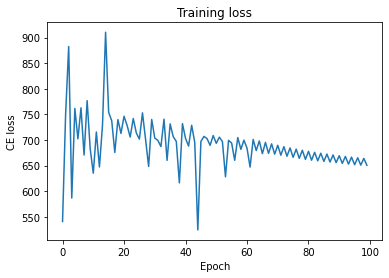

In [12]:
# For Q4
logistic_reg.plot_curve()

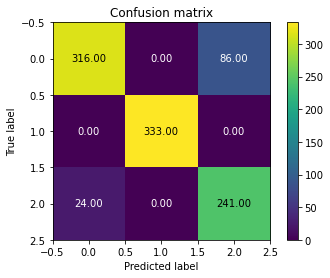

In [13]:
# For Q5
logistic_reg.show_confusion_matrix(X_test, y_test)

# Fisher's Linear Discriminant Analysis

In [14]:
fld = FLD()

fld.fit(X_train, y_train)

In [15]:
# For Q6
print("Class mean vector: ", fld.mean_vectors)

Class mean vector:  [[-4.17505764  6.35526804]
 [-9.43385176 -4.87830741]
 [-2.54454008  7.53144179]]


In [16]:
# For Q7
print("Within-class scatter matrix SW: ", fld.sw)

Within-class scatter matrix SW:  [[11190.71043049 20368.6120689 ]
 [20368.6120689  43588.79888566]]


In [17]:
# For Q8
print("Between-class scatter matrix SB: ", fld.sb)

Between-class scatter matrix SB:  [[ 28930.94537388 -16146.88066567]
 [-16146.88066567   9011.86435017]]


In [18]:
# For Q9
print("W: ", fld.w)

W:  [0.90001598 0.48735181]


FLD using class mean, accuracy:  0.66


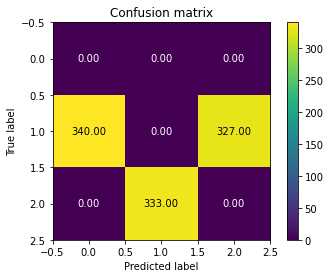

In [19]:
# For Q10
y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))

fld.show_confusion_matrix(y_test, y_pred)

In [20]:
# For Q11
y_pred_k1 = fld.predict_using_knn(X_train, y_train, X_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))

y_pred_k2 = fld.predict_using_knn(X_train, y_train, X_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))

y_pred_k3 = fld.predict_using_knn(X_train, y_train, X_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))

y_pred_k4 = fld.predict_using_knn(X_train, y_train, X_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))

y_pred_k5 = fld.predict_using_knn(X_train, y_train, X_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

FLD using knn (k=1), accuracy:  0.846
FLD using knn (k=2), accuracy:  0.827
FLD using knn (k=3), accuracy:  0.861
FLD using knn (k=4), accuracy:  0.863
FLD using knn (k=5), accuracy:  0.872


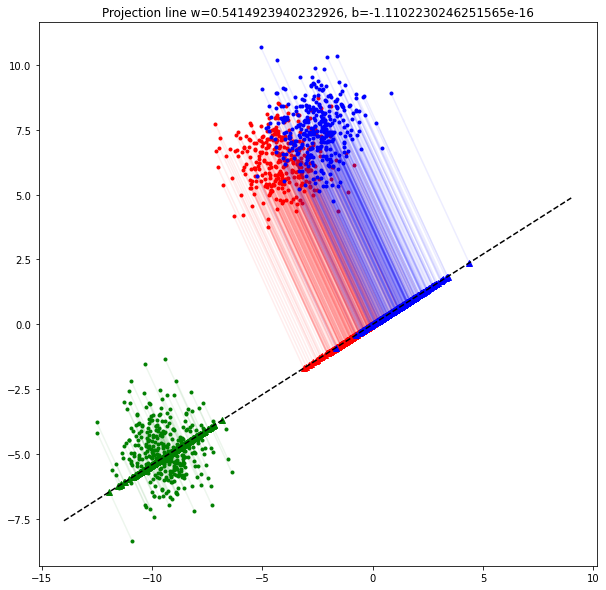

In [21]:
# For Q12, using only training data
fld.plot_projection(X_train, y_train)
# fld.plot_projection(X_train, y_train, shift_slope=[0,5])

# Train your own model on provided dataset.
You can only using 1) **Fisher's Linear Discriminant** or 2) **Logistic Regression** that you have implemented above.

In [22]:
df_train = pd.DataFrame(pd.read_csv("./PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))

In [23]:
df_train.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00668,0.00192,0.682,0.996,2.0
1,0.00680,0.00106,0.503,0.996,1.0
2,0.00742,0.00106,0.482,0.991,1.0
3,0.00685,0.00178,0.650,0.998,2.0
4,0.00680,0.00163,0.623,0.996,2.0


In [24]:
df_test.head()

,Feature1,Feature2,Feature3,Feature4,Target
0,0.00699,0.000877,0.451,0.994,NaN
1,0.00736,0.001370,0.549,0.998,NaN
2,0.00687,0.001420,0.580,0.992,NaN
3,0.00752,0.002520,0.737,0.996,NaN
4,0.00685,0.000910,0.464,0.992,NaN


In [25]:
x_train = df_train.drop(['Target'], axis=1)
x_val = df_val.drop(['Target'], axis=1)
x_test = df_test.drop(['Target'], axis=1)

y_train = df_train['Target']
y_val = df_val['Target']
# x_train.head(), y_train.head()

In [26]:
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
x_test = x_test.to_numpy()

y_train = y_train.to_numpy().astype(np.int64)#.reshape(-1,1)
y_val = y_val.to_numpy().astype(np.int64)#.reshape(-1,1)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape)

(1703, 4) (1703,)
(730, 4) (730,)
(5677, 4)


In [27]:
y_train = one_hot_encode(y_train)
y_val  = one_hot_encode(y_val)

In [28]:
# NORMALIZATION
_mean = x_train.mean(0)
_std = x_train.std(0)

x_train = (x_train -_mean) / _std
x_val = (x_val -_mean) / _std
x_test = (x_test -_mean) / _std 

In [29]:
# # Data processing
# def polynomial(X):
#     X3 = (X[:,0] * X[:,1]).reshape(-1,1)
#     X4 = (X[:,1] * X[:,2]).reshape(-1,1)
#     X5 = (X[:,0]**2).reshape(-1,1)
#     X6 = (X[:,2] * X[:,3]).reshape(-1,1)
#     X7 = (X[:,1]**2).reshape(-1,1)
#     X8 = (X[:,3] * X[:,1]).reshape(-1,1)
#     X9 =(X[:,2]**2).reshape(-1,1)
#     X10 = (X[:,3] * X[:,0]).reshape(-1,1)
#     X11 =(X[:,3]**2).reshape(-1,1)
    
#     X = np.concatenate((X, X3,X4,X5,X6,X7,X8,X9,X10,X11), -1)
#     # X = np.concatenate((X, X3,X4), -1)
#     return X

# x_train = polynomial(x_train)
# x_val = polynomial(x_val)
# x_test = polynomial(x_test)

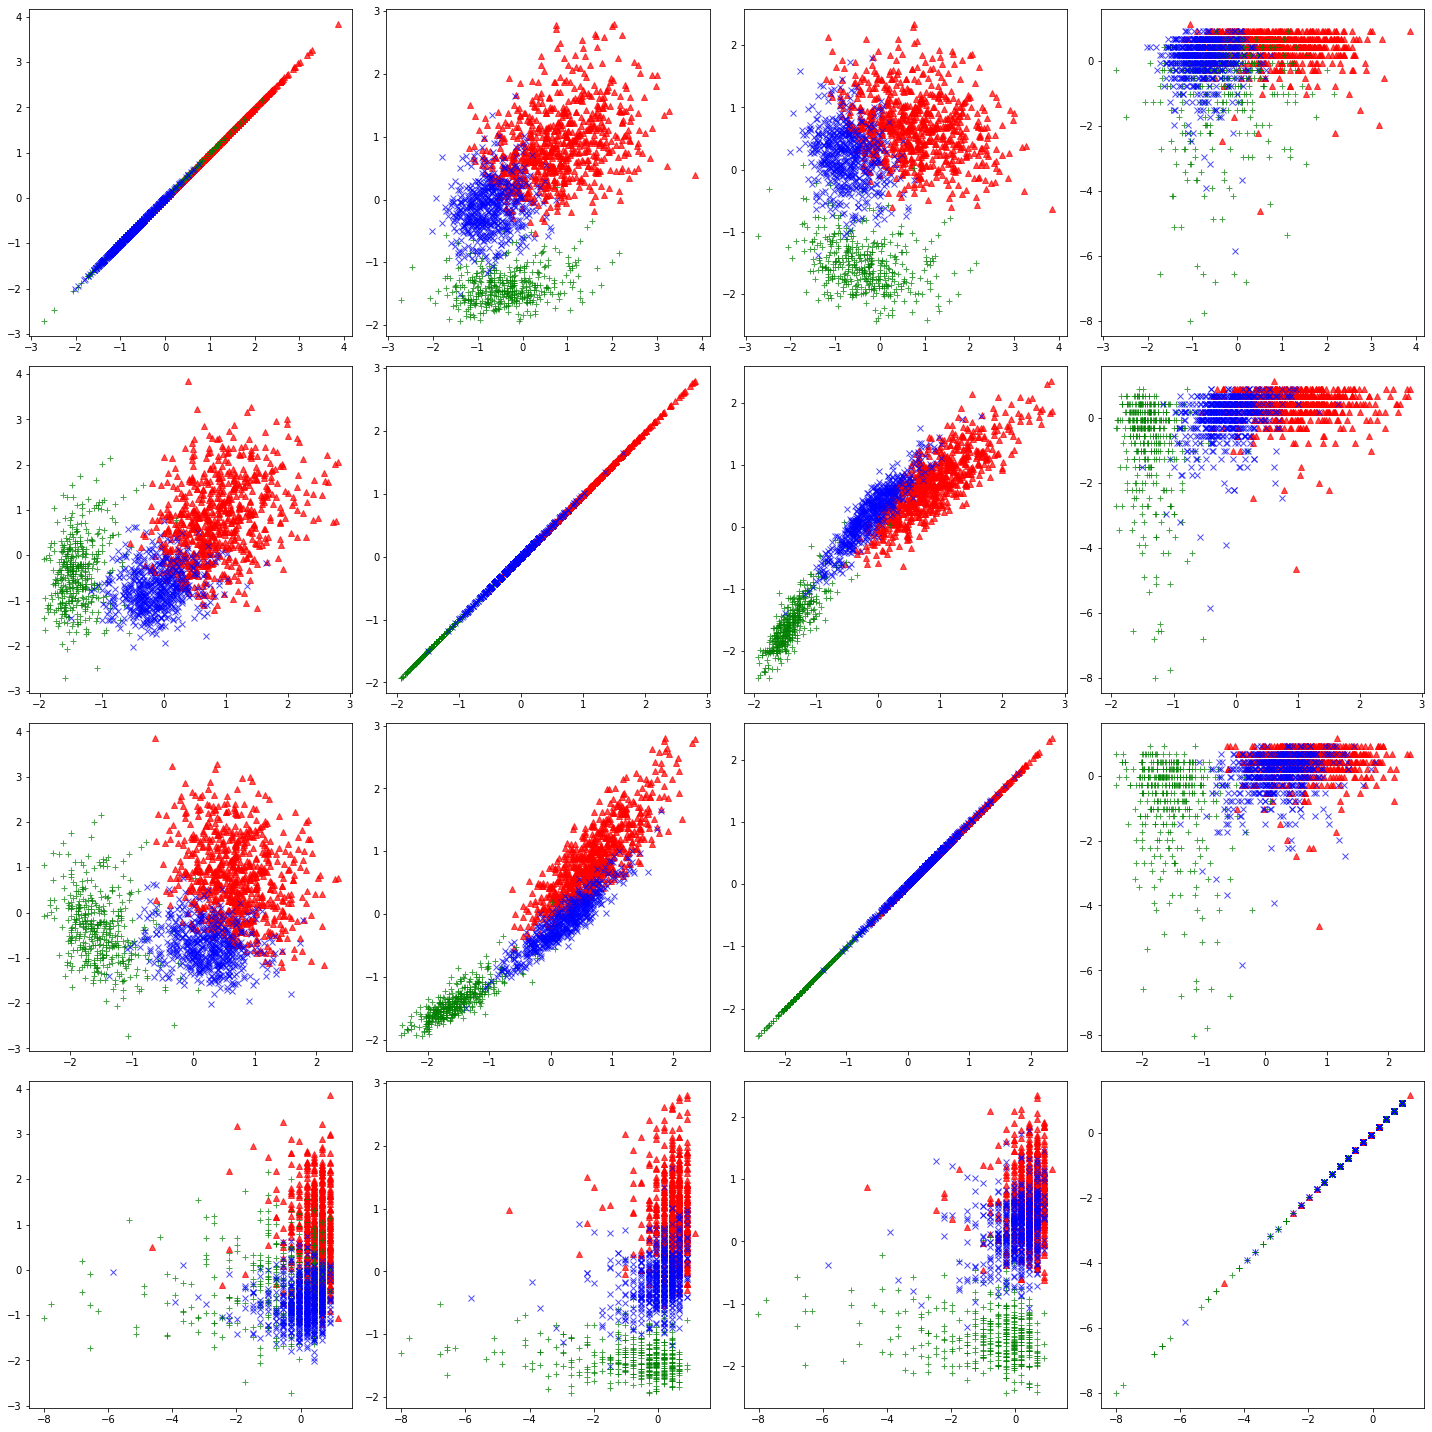

In [30]:
# DATA VISUALIZATION
def visualize(X, y):
    _, x_features = X.shape
    n_samples, n_features = y.shape


    colors = ['r', 'g', 'b']
    marks = ['^', '+', 'x']
    fig, ax = plt.subplots(x_features,x_features, figsize=(20,20))
    i, j = 0, 0
    for l in range(x_features**2):
        for k in range(n_features):
            cond = y[:,k] == 1
            ax[i,j].plot(X[cond,i], X[cond,j], colors[k]+marks[k], alpha=0.7)
        i+=1
        if i >= x_features:
            j+=1
            i=0
    plt.tight_layout()

visualize(x_train, y_train)
# visualize(x_val, y_val)

In [31]:
lr = 1e-4
batch_size = x_train.shape[0]//10
epoch = 15000

print(batch_size)

logistic_reg = MultiClassLogisticRegression(x_train.shape[-1], y_train.shape[-1])

170


In [32]:
logistic_reg.fit(x_train, y_train, lr=lr, batch_size=batch_size, epoch=epoch)

Training acc:  0.9365825014679976
Testing acc:  0.9246575342465754


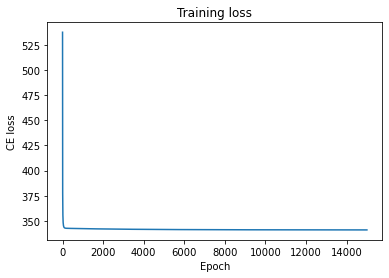

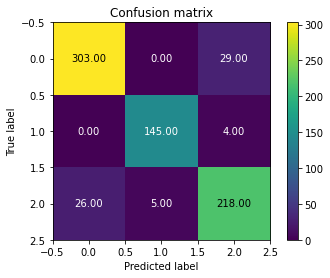

In [33]:
print('Training acc: ', logistic_reg.evaluate(x_train, y_train))
print('Testing acc: ', logistic_reg.evaluate(x_val, y_val))
logistic_reg.plot_curve()
logistic_reg.show_confusion_matrix(x_val, y_val)

In [34]:
# Just check how FLD doing
fld = FLD()
fld.fit(x_train, y_train)
y_pred_k5 = fld.predict_using_knn(x_train, y_train, x_val, k=20)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_val, y_pred_k5))

FLD using knn (k=5), accuracy:  0.5726027397260274


In [35]:
test_pred = logistic_reg.predict(x_test)
test_pred = np.argmax(test_pred, 1)
print("test_pred shape: ", test_pred.shape)

test_pred shape:  (5677,)


# Output the csv file

In [36]:
# For Q13
df_test = pd.DataFrame(pd.read_csv("./PR_HW2_test.csv"))
df_test["Target"] = test_pred
df_test.to_csv("output.csv")